<a href="https://colab.research.google.com/github/holezekki99/JODA2022/blob/harjoitusty%C3%B6/Goalie_salary_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goalie salary predictor

In this workbook we're trying to make a model that could predict what would be the fair salary for NHL goalie based on his performance.

The statistical data for goelies performance is downloaded from Moneypuck.com website. The earnings are webscraped from spotrac.com.

### Aquiring data

We need goalie game statistics first. Separate files for every season. We'll be looking 3 year history:

In [1]:
# Create data-directory
!mkdir ./data

In [2]:
years = ['2019', '2020', '2021']

In [3]:
# Get the data for seasons starting 2019-2021 and write them to files
import pandas as pd
import requests

for i in years:
  year = str(i)
  url = ('https://moneypuck.com/moneypuck/playerData/seasonSummary/' + year + '/regular/goalies.csv')
  page = requests.get(url)
  r = requests.get(url)
  fname = ('./data/stat' + year + '.csv')
  open(fname, 'wb').write(r.content)


Next step is to webscrape salary information for seasons 2018-2022 and write the result into salaries.csv file.

We use beautifulsoup library for scraping:

In [78]:
from bs4 import BeautifulSoup

# Defining of the dataframe, we collect only name, year and caphit
df = pd.DataFrame(columns=['name', 'season', 'caphit'])

for i in years:
  year = str(i)
  url = ('https://www.spotrac.com/nhl/positional/' + year + '/goaltender/active-cap/')
  page = requests.get(url)
  soup = BeautifulSoup(page.content, 'html.parser')
  table = soup.find_all('table')[1]

  table = soup.find_all('table')[1] # Table 1 is the list of goalies
  # Collecting Ddata
  for row in table.tbody.find_all('tr'):    
    # Find all data for each column
    columns = row.find_all('td')
    if(columns != []):
      name = columns[2].text.strip()
      # Make a new column familyname.
      # familyname = name.split()[-1]
      # Correct Vasilevskiy familyname
      if name == 'Andrei Vasilevski':
        name = 'Andrei Vasilevskiy'
      year = year
      caphit = columns[3].text.strip()
      df = df.append({'name': name,  'season': year, 'caphit': caphit}, ignore_index=True)


In [79]:
df.head()

,name,season,caphit
0,Carey Price,2019,"$10,500,000"
1,Sergei Bobrovsky,2019,"$10,000,000"
2,Henrik Lundqvist,2019,"$8,500,000"
3,Marc-Andre Fleury,2019,"$7,000,000"
4,Tuukka Rask,2019,"$7,000,000"


In [80]:
df.to_csv('./data/salaries.csv', index=False)  

### Data cleaning
Next step is to merge the stats-datafiles into a single dataframe, investigate what we have and clean the data if needed:

We start by merging all stat-files into stat_df dataframe:

In [68]:
# Make one dataframe out of multiple statistical files (https://www.geeksforgeeks.org/how-to-merge-multiple-csv-files-into-a-single-pandas-dataframe/)

# importing libraries
import glob
import os
  
# merging the files
stat_files = os.path.join("./data", "stat*.csv")
  
# A list of all joined files is returned
stats_list = glob.glob(stat_files)
  
# Finally, the files are joined
stat_df = pd.concat(map(pd.read_csv, stats_list), ignore_index=True)

# Use only family name. Datasources seem to have differencies in firstnames. (https://pandas.pydata.org/docs/getting_started/intro_tutorials/10_text_data.html)
#stat_df['name'] = stat_df['name'].str.split().str.get(1)
#stat_df.head()

In [69]:
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   1510 non-null   int64  
 1   season                     1510 non-null   int64  
 2   name                       1510 non-null   object 
 3   team                       1510 non-null   object 
 4   position                   1510 non-null   object 
 5   situation                  1510 non-null   object 
 6   games_played               1510 non-null   int64  
 7   icetime                    1510 non-null   float64
 8   xGoals                     1510 non-null   float64
 9   goals                      1510 non-null   float64
 10  unblocked_shot_attempts    1510 non-null   float64
 11  xRebounds                  1510 non-null   float64
 12  rebounds                   1510 non-null   float64
 13  xFreeze                    1510 non-null   float

We have multiple rows for each season per goalie. There is a row for all different game situations (5vs.5, 5vs.4 etc). We're not interested to the difference in different situations, but keep only the "all" rows: 

In [81]:
# remove rows using the drop() function
stat_df.drop(stat_df.index[stat_df['situation'] != 'all'], inplace=True)
stat_df.head()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
1,8470147,2019,Curtis McElhinney,T.B,G,all,18,64921.0,51.92,53.0,...,46.0,17.48,18.77,15.67,19.0,15.0,19.0,235.0,0.0,0.0
6,8474596,2019,Jake Allen,STL,G,all,24,78105.0,53.19,49.0,...,48.0,17.57,21.07,14.54,23.0,14.0,12.0,267.0,0.0,0.0
11,8480022,2019,Michael Dipietro,VAN,G,all,1,503.0,0.47,1.0,...,0.0,0.12,0.35,0.00,0.0,1.0,0.0,2.0,0.0,0.0
16,8478048,2019,Igor Shesterkin,NYR,G,all,12,41495.0,32.09,29.0,...,28.0,11.43,11.85,8.81,10.0,9.0,10.0,213.0,0.0,0.0
21,8478499,2019,Adin Hill,ARI,G,all,13,38446.0,30.19,28.0,...,22.0,11.36,11.41,7.42,11.0,10.0,7.0,155.0,2.0,1.0


In [71]:
stat_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 1 to 1506
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   302 non-null    int64  
 1   season                     302 non-null    int64  
 2   name                       302 non-null    object 
 3   team                       302 non-null    object 
 4   position                   302 non-null    object 
 5   situation                  302 non-null    object 
 6   games_played               302 non-null    int64  
 7   icetime                    302 non-null    float64
 8   xGoals                     302 non-null    float64
 9   goals                      302 non-null    float64
 10  unblocked_shot_attempts    302 non-null    float64
 11  xRebounds                  302 non-null    float64
 12  rebounds                   302 non-null    float64
 13  xFreeze                    302 non-null    float6

The datatypes in the statististics dataframe are ok. The dataset is good quality, no need for further cleaning.

The next step is to load salary.csv into sal_df:

In [82]:
# Load salaries.csv into a dataframe

sal_df = pd.read_csv('./data/salaries.csv')
sal_df.head()

,name,season,caphit
0,Carey Price,2019,"$10,500,000"
1,Sergei Bobrovsky,2019,"$10,000,000"
2,Henrik Lundqvist,2019,"$8,500,000"
3,Marc-Andre Fleury,2019,"$7,000,000"
4,Tuukka Rask,2019,"$7,000,000"


In [83]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    225 non-null    object
 1   season  225 non-null    int64 
 2   caphit  225 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB


In [84]:
# Convert year into numeric value:
sal_df['season'] = sal_df['season'].astype(int)

# Convert caphit into numeric value.
sal_df['caphit'] = sal_df['caphit'].replace("[$,]", "", regex=True).astype(int)

In [85]:
sal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    225 non-null    object
 1   season  225 non-null    int64 
 2   caphit  225 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 5.4+ KB


Now we need to merge the dataframes. Insert into stat_df a new column with salary information ("caphit").

In [33]:
stat_df.shape


(302, 36)

In [ ]:
sal_df.shape

(225, 3)

Use merge method with outer left join. We keep all the values in stats dataframe and include the caphit (salary) from salary dataframe.

In [86]:
merged_df = pd.merge(stat_df, sal_df, how="left", on=["season", "name"])
merged_df

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,caphit
0,8470147,2019,Curtis McElhinney,T.B,G,all,18,64921.0,51.92,53.0,...,17.48,18.77,15.67,19.0,15.0,19.0,235.0,0.0,0.0,1300000.0
1,8474596,2019,Jake Allen,STL,G,all,24,78105.0,53.19,49.0,...,17.57,21.07,14.54,23.0,14.0,12.0,267.0,0.0,0.0,4350000.0
2,8480022,2019,Michael Dipietro,VAN,G,all,1,503.0,0.47,1.0,...,0.12,0.35,0.00,0.0,1.0,0.0,2.0,0.0,0.0,NaN
3,8478048,2019,Igor Shesterkin,NYR,G,all,12,41495.0,32.09,29.0,...,11.43,11.85,8.81,10.0,9.0,10.0,213.0,0.0,0.0,925000.0
4,8478499,2019,Adin Hill,ARI,G,all,13,38446.0,30.19,28.0,...,11.36,11.41,7.42,11.0,10.0,7.0,155.0,2.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,8480843,2021,Lukas Dostal,ANA,G,all,4,12087.0,8.62,10.0,...,3.55,3.02,2.04,4.0,5.0,1.0,45.0,0.0,0.0,NaN
298,8480382,2021,Alexandar Georgiev,NYR,G,all,33,104766.0,78.16,85.0,...,26.51,27.42,24.23,33.0,25.0,27.0,408.0,0.0,0.0,NaN
299,8475831,2021,Philipp Grubauer,SEA,G,all,55,186685.0,130.26,164.0,...,43.26,47.19,39.81,57.0,62.0,45.0,672.0,0.0,0.0,NaN
300,8475839,2021,Louis Domingue,PIT,G,all,2,7125.0,7.85,4.0,...,2.20,3.43,2.22,0.0,3.0,1.0,32.0,0.0,0.0,750000.0


Examine the dataset and look for seasons played per goalie. The idea is to remove those goalies that have not played too many games per season.

In [90]:
df1 = stat_df
df1 = df1.sort_values(by=['name', 'season'], ignore_index=True)
df1

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties
0,8477180,2019,Aaron Dell,S.J,G,all,33,110081.0,90.41,92.0,...,89.0,30.19,32.56,27.66,30.0,32.0,30.0,406.0,0.0,0.0
1,8477180,2020,Aaron Dell,N.J,G,all,7,19150.0,12.26,22.0,...,10.0,4.86,4.64,2.76,11.0,9.0,2.0,48.0,0.0,0.0
2,8477180,2021,Aaron Dell,BUF,G,all,12,33923.0,33.64,38.0,...,33.0,10.33,12.20,11.11,11.0,14.0,13.0,130.0,2.0,1.0
3,8478903,2021,Adam Huska,NYR,G,all,1,3582.0,3.14,7.0,...,2.0,0.78,1.35,1.01,1.0,5.0,1.0,19.0,0.0,0.0
4,8479530,2019,Adam Werner,COL,G,all,2,5270.0,4.02,5.0,...,1.0,1.88,1.83,0.30,4.0,0.0,1.0,23.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,8478024,2021,Ville Husso,STL,G,all,40,140474.0,113.54,100.0,...,97.0,41.03,42.50,30.01,41.0,34.0,25.0,491.0,0.0,0.0
298,8477970,2020,Vitek Vanecek,WSH,G,all,37,126929.0,87.72,95.0,...,81.0,30.84,29.40,27.47,36.0,34.0,25.0,426.0,0.0,0.0
299,8477970,2021,Vitek Vanecek,WSH,G,all,42,139043.0,97.64,103.0,...,88.0,31.45,36.53,29.66,34.0,36.0,33.0,546.0,0.0,0.0
300,8477457,2021,Zach Fucale,WSH,G,all,4,10295.0,7.39,5.0,...,8.0,2.34,2.64,2.42,3.0,0.0,2.0,40.0,0.0,0.0


Examine how many seasons (between 2019-2021) goalies have played.

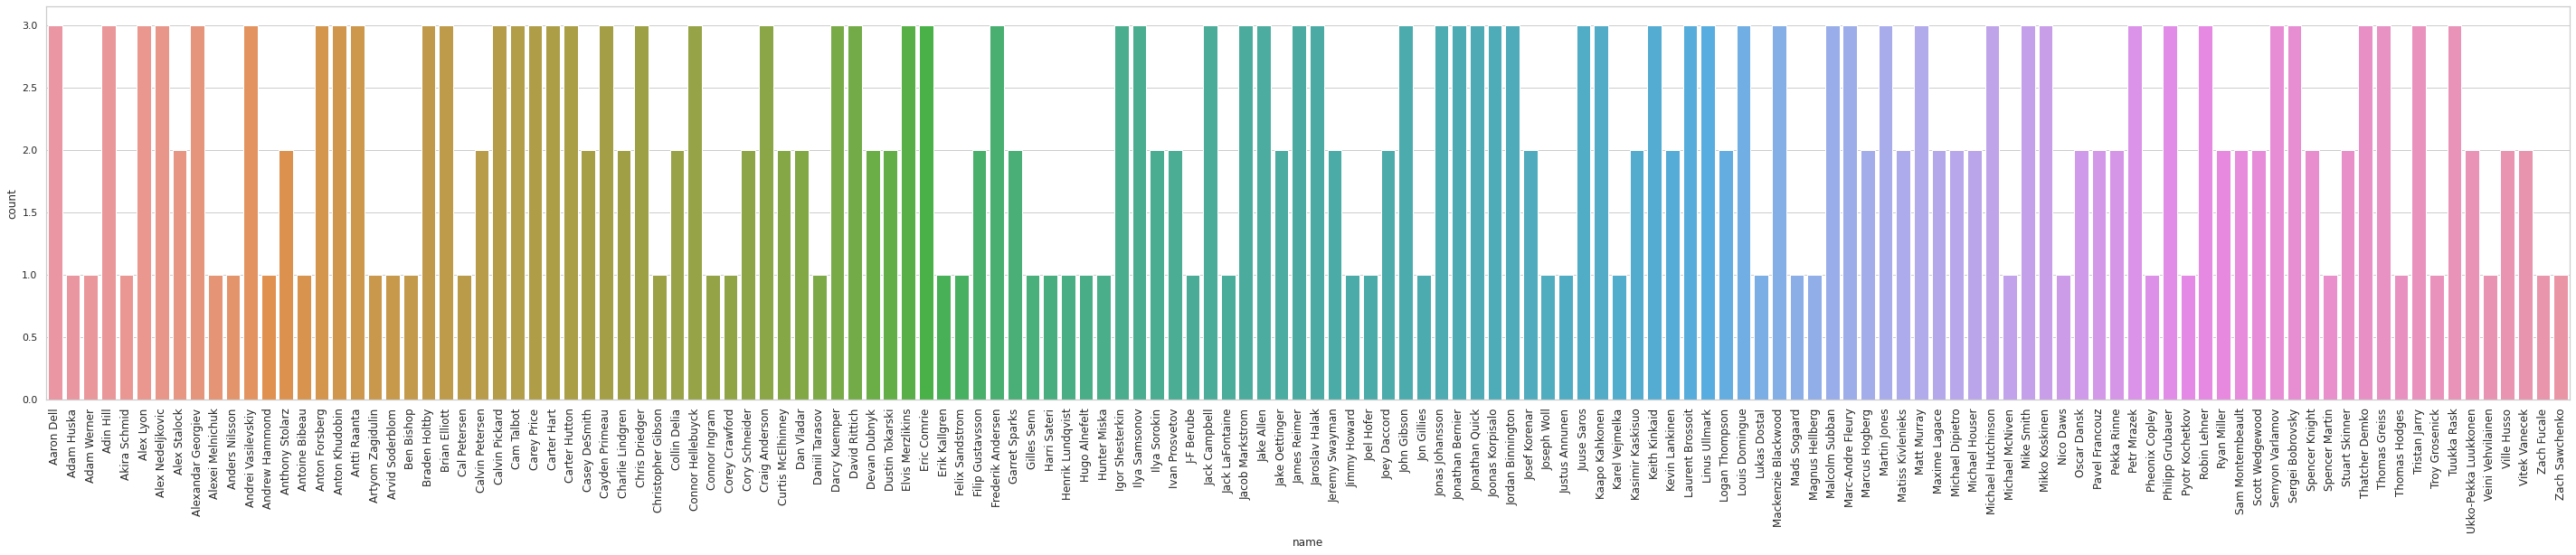

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")
sns.countplot(x = 'name', data = df1)
plt.rcParams["figure.figsize"] = (50,8)
plt.xticks(rotation=90, fontsize=12)
plt.show()

Find goalies that have played more than 5 games in one season:

In [108]:
df = merged_df
df = df[df.groupby('name')['games_played'].transform('max') > 5]
df.shape

(261, 37)

In [109]:
merged_df.shape

(302, 37)

In [ ]:
df = merged_df
df = df[df.groupby('name')['games_played'].transform('sum') > 25]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 0 to 301
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   218 non-null    int64  
 1   season                     218 non-null    int64  
 2   name                       218 non-null    object 
 3   team                       218 non-null    object 
 4   position                   218 non-null    object 
 5   situation                  218 non-null    object 
 6   games_played               218 non-null    int64  
 7   icetime                    218 non-null    float64
 8   xGoals                     218 non-null    float64
 9   goals                      218 non-null    float64
 10  unblocked_shot_attempts    218 non-null    float64
 11  xRebounds                  218 non-null    float64
 12  rebounds                   218 non-null    float64
 13  xFreeze                    218 non-null    float64

We see that not all goalies have played in every season.

We can replace goalies NaN caphit values by inserting their average caphit value to those years caphit is missing.

In [ ]:
# fill caphit nan values (had not played for that season) with players average caphit (https://stackoverflow.com/questions/19966018/pandas-filling-missing-values-by-mean-in-each-group)
df['caphit'] = df['caphit'].fillna(df.groupby('name')['caphit'].transform('mean')) 
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,caphit
0,8475156,2021,Koskinen,EDM,G,all,45,157718.0,129.16,136.0,...,45.27,48.39,35.50,49.0,53.0,34.0,528.0,4.0,2.0,4500000.0
1,8478499,2021,Hill,SJS,G,all,25,82573.0,56.91,61.0,...,19.80,20.83,16.29,22.0,21.0,18.0,354.0,0.0,0.0,800000.0
2,8478009,2021,Sorokin,NYI,G,all,52,184337.0,135.77,123.0,...,52.35,46.82,36.60,59.0,38.0,26.0,826.0,0.0,0.0,4000000.0
3,8476434,2021,Gibson,ANA,G,all,56,194135.0,157.74,172.0,...,55.84,60.81,41.07,73.0,74.0,25.0,729.0,12.0,6.0,6400000.0
4,8476341,2021,Forsberg,OTT,G,all,46,154287.0,129.46,121.0,...,42.33,52.33,34.79,40.0,50.0,31.0,638.0,2.0,1.0,900000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,8470860,2020,Halak,BOS,G,all,19,65401.0,37.77,46.0,...,13.95,15.48,8.33,18.0,19.0,9.0,210.0,0.0,0.0,2250000.0
298,8471695,2020,Rask,BOS,G,all,24,83787.0,56.64,53.0,...,17.30,23.59,15.74,19.0,20.0,14.0,257.0,0.0,0.0,7000000.0
299,8478048,2020,Shesterkin,NYR,G,all,35,113941.0,85.99,83.0,...,28.81,29.87,27.31,30.0,28.0,25.0,443.0,0.0,0.0,925000.0
300,8477992,2020,Johansson,COL,G,all,15,49010.0,30.25,39.0,...,10.65,13.08,6.52,16.0,14.0,9.0,148.0,0.0,0.0,700000.0


Caphit column has 108 NaN values. Let's examine what they are:

In [ ]:
nan_values = df[df['caphit'].isna()]
nan_values['name'].unique

<bound method Series.unique of Series([], Name: name, dtype: object)>

Drop remaining rows with caphit as NaN:

In [ ]:
df = df[df['caphit'].notna()]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 218 entries, 0 to 301
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   playerId                   218 non-null    int64  
 1   season                     218 non-null    int64  
 2   name                       218 non-null    object 
 3   team                       218 non-null    object 
 4   position                   218 non-null    object 
 5   situation                  218 non-null    object 
 6   games_played               218 non-null    int64  
 7   icetime                    218 non-null    float64
 8   xGoals                     218 non-null    float64
 9   goals                      218 non-null    float64
 10  unblocked_shot_attempts    218 non-null    float64
 11  xRebounds                  218 non-null    float64
 12  rebounds                   218 non-null    float64
 13  xFreeze                    218 non-null    float64

Finally the dataframe looks ok.

### Data describing

In [ ]:
df.tail()

,playerId,season,name,team,position,situation,games_played,icetime,xGoals,goals,...,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals,blocked_shot_attempts,penalityMinutes,penalties,caphit
295,8470860,2020,Halak,BOS,G,all,19,65401.0,37.77,46.0,...,13.95,15.48,8.33,18.0,19.0,9.0,210.0,0.0,0.0,2250000.0
298,8471695,2020,Rask,BOS,G,all,24,83787.0,56.64,53.0,...,17.30,23.59,15.74,19.0,20.0,14.0,257.0,0.0,0.0,7000000.0
299,8478048,2020,Shesterkin,NYR,G,all,35,113941.0,85.99,83.0,...,28.81,29.87,27.31,30.0,28.0,25.0,443.0,0.0,0.0,925000.0
300,8477992,2020,Johansson,COL,G,all,15,49010.0,30.25,39.0,...,10.65,13.08,6.52,16.0,14.0,9.0,148.0,0.0,0.0,700000.0
301,8481519,2020,Knight,FLA,G,all,4,12414.0,6.90,8.0,...,2.69,1.27,2.94,3.0,1.0,4.0,35.0,0.0,0.0,925000.0


Start visually describe the salarydata. In order to understand the current situation in salaries, let's look only season 21-22.



In [ ]:
df21 = df
df21 = df21[df21.season == 2021]
df21.shape

(73, 37)

We're now looking the season 21-22 salary information of 73 goalies that have played in season at least 25 games since the start of season 2019-2022.

First we use boxplot from seaborn library to find:
- min and max caphits
- the blue box represents interquartile range (IQR) (25th to the 75th percentile)
- outliers, if any

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()
sns.set_style("whitegrid")

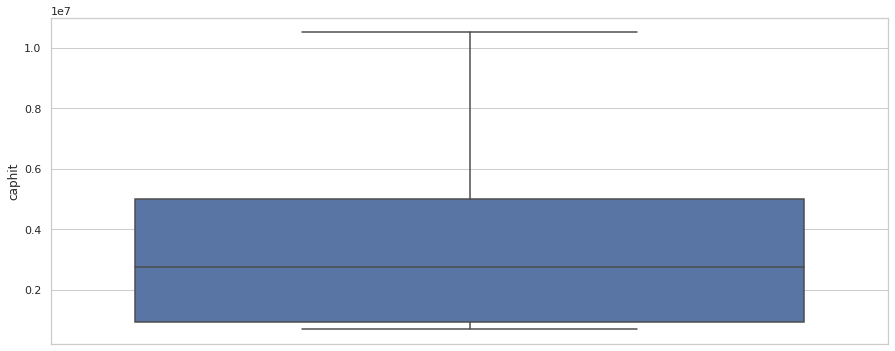

In [ ]:
sns.boxplot(data = df21, y = 'caphit')

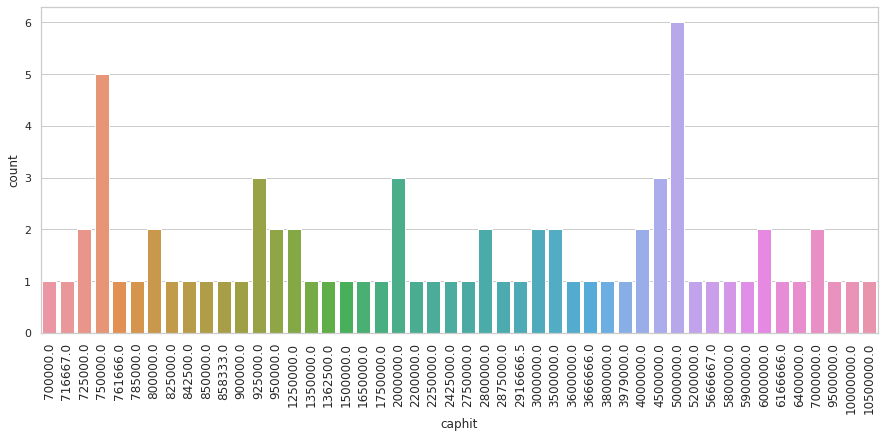

In [ ]:
sns.countplot(x = 'caphit', data = df21)
plt.rcParams["figure.figsize"] = (15,6)
plt.xticks(rotation=90, fontsize=12)
plt.show()

-----